In [1]:
import sys
from pathlib import Path

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

# parameters
dataset_name = 'CIFAR10'
data_root = Path.cwd().parent / 'data'

In [3]:
from src import prepare_datasets, ModelTrainer, accuracy
from models.eight_layer_conv_net.architecture import EightLayerConvNet
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import transforms

### Model 1: Eight Layer Conv Net

The EightLayerConvNet's backbone is inspired by VGG16, alternating convolutional layers with a kernel size of 3 and max pooling layers at  and ReLU activation functions in "blocks", with the max pooling happening at the end of each block. However, since we're working with CIFAR-10's 32x32 images rather than ImageNet's 224x224 images, most other architectural aspects differ significantly from the original VGG design.

There are 2 convolutional layers in each block, and the number of filters doubles after each block. The final layer is a global average pooling layer, followed by a fully connected layer with 512 neurons. This architecture is designed to be simple and efficient, with a focus on depth and feature extraction.

We are using BatchNorm2d with a momentum of 0.6, and ReLU activation functions with inplace=True. The reason for using BatchNorm2d is to stabilize the training process and prevent overfitting. The momentum parameter is set to 0.6, which is a common value for this parameter in practice. Note that we are not using bias in the convolutional layers, this is because we are using BatchNorm2d....

The ReLU activation function is used to introduce non-linearity into the network, allowing it to learn more complex patterns. The inplace=True parameter is used to save memory by modifying the input tensor in place.
The convolutions are using padding='same'. The last pooling layer is using AdaptiveAvgPool2d, which is a global average pooling layer.

We have two fully connected layers, the first one with 512 neurons and the second one with 10 neurons. The 10 neurons are the output neurons, one for each class in the dataset. The last layer is not using bias, differing from the first fc-layer this is because we are using a cross-entropy loss function, and the softmax function is applied in the loss function.

The model is trained for 20 epochs, with a batch size of 1024. The learning rate is set to 0.1, and the momentum is set to 0.9. The weight decay is set to 0.01. The scheduler is a MultiStepLR scheduler with milestones at 8 and 13, and a gamma of 0.1. We are using SGD as our optimizer, and the loss function is CrossEntropyLoss.

There is also augmentation of the data, we are using random cropping and random horizontal flipping. I've seen multiple github repos using similiar augmentations, and they seem to work well. I believe I saw it first at [pytorch-cifar](https://github.com/kuangliu/pytorch-cifar/blob/master/main.py).

Next, I will try to succinctly explain some of the methods used in this architecture, since they are outside the scope of the course.

- Why are we using BatchNorm2d? In what paper was it first introduced?
- Give short explanation of the momentum parameter in BatchNorm2d, use the simple math to explain it.
- How comes we can set the bias to false just because of batchnorm?
- What is the purpose of the inplace=True parameter in the ReLU activation function?
- What is the purpose of the nn.AdaptiveAvgPool2d((1, 1)) layer? When was this technique first popularized?
- Go over momentum for SGD, show simple math, and what it does.






### Model 1: Eight Layer Conv Net

The EightLayerConvNet's backbone is inspired by VGG16, alternating convolutional layers with a kernel size of 3 and max pooling layers at the end of each block. However, since we're working with CIFAR-10's 32x32 images rather than ImageNet's 224x224 images, most other architectural aspects differ significantly from the original VGG design.

Each block contains two convolutional layers, with the number of filters doubling after each block. We use AdaptiveAvgPool2d for global pooling in the final layer, followed by a fully connected layer with 512 neurons. This architecture prioritizes depth and efficient feature extraction while maintaining simplicity.

We use BatchNorm2d with a momentum of 0.6 and ReLU activation functions with inplace=True. BatchNorm2d helps stabilize training and prevent overfitting. Since we're using BatchNorm2d, we can omit the bias terms in our convolutional layers - I'll explain why in the technical details below.

The convolutions use padding='same'. Our classifier consists of two fully connected layers: the first with 512 neurons (with bias) and the second with 10 neurons (without bias, since we're using cross-entropy loss with softmax).

For training, we use:
- Batch size: 1024
- Initial learning rate: 0.1
- SGD optimizer with momentum: 0.9
- Weight decay: 0.01
- MultiStepLR scheduler (milestones: [8, 13], gamma: 0.1)
- Data augmentation: random cropping and horizontal flipping (inspired by various CIFAR-10 implementations, notably [pytorch-cifar](https://github.com/kuangliu/pytorch-cifar))

Let's dive into some of the technical details that weren't covered in our course:


#### Technical Deep Dive

**BatchNorm2d - What and Why?**  
BatchNorm was introduced in 2015 by Ioffe and Szegedy in their paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167). The idea is brilliantly simple: normalize the data not just at input but at each layer. This helps solve the "internal covariate shift" problem, where the distribution of each layer's inputs keeps changing during training.

Think of it this way - if you're trying to hit a target, it's much harder if the target keeps moving. BatchNorm keeps our "target" steady by normalizing the data at each layer, making training more stable and allowing for higher learning rates.






Files already downloaded and verified
Files already downloaded and verified
Using FP16 (half precision) training
[epoch 01] train loss: 1.6252 | val loss: 1.7518 | accuracy: 39.22%
Validation loss decreased (inf --> 1.7518). Saving model.
[epoch 02] train loss: 1.1885 | val loss: 1.4092 | accuracy: 49.24%
Validation loss decreased (1.7518 --> 1.4092). Saving model.
[epoch 03] train loss: 0.9774 | val loss: 1.1750 | accuracy: 59.15%
Validation loss decreased (1.4092 --> 1.1750). Saving model.
[epoch 04] train loss: 0.8948 | val loss: 1.2154 | accuracy: 58.65%
EarlyStopping counter: 1 out of 3
[epoch 05] train loss: 0.7036 | val loss: 0.6529 | accuracy: 78.49%
Validation loss decreased (1.1750 --> 0.6529). Saving model.
[epoch 06] train loss: 0.6121 | val loss: 0.6036 | accuracy: 79.98%
Validation loss decreased (0.6529 --> 0.6036). Saving model.
[epoch 07] train loss: 0.5646 | val loss: 0.5656 | accuracy: 81.43%
Validation loss decreased (0.6036 --> 0.5656). Saving model.
[epoch 08] tra

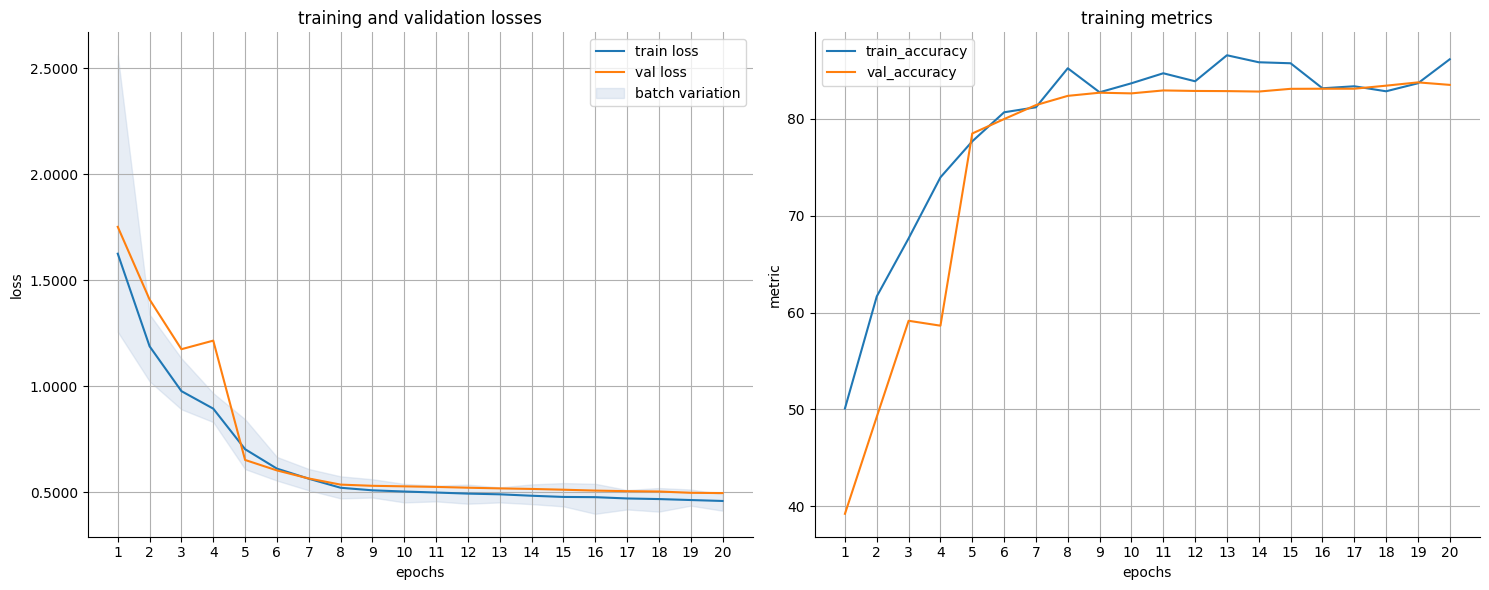

In [6]:
from src import prepare_datasets, ModelTrainer, accuracy
from models.eight_layer_conv_net.architecture import EightLayerConvNet
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

trainset, valset, testset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_val=transform_val,
    normalize=False,
    use_validation_split=True,
)

def train_model(model, model_name, num_epochs=200):
    optimizer = SGD(
        model.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=0.01,
    )
    
    scheduler = MultiStepLR(
        optimizer,
        milestones=[8, 13],
        gamma=0.1
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=1024,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=3,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model1 = EightLayerConvNet()
trainer1 = train_model(model1, "EightLayerConvNet", num_epochs=20)

In [3]:
test_results_1 = trainer1.evaluate_on_test(test_set=testset)


Loading Best Model for Test Evaluation
Test Loss: 0.4924 | accuracy: 84.42


In [ ]:
from src import MetricsPlotter
import numpy as np

predictions = test_results_1['predictions']
true_labels = test_results_1['true_labels']

# calculate per-class accuracy
class_correct = np.zeros(10)
class_total = np.zeros(10)
for i in range(len(true_labels)):
    label = true_labels[i]
    class_total[label] += 1
    if predictions[i] == label:
        class_correct[label] += 1

per_class_accuracy = (class_correct / class_total) * 100

# plot
plotter = MetricsPlotter()
ax = plotter.plot_class_accuracy(per_class_accuracy, testset.classes, dataset_name="CIFAR-10")

## Model 2: Eight Layer Conv Net Modified

Files already downloaded and verified
Files already downloaded and verified
Using FP16 (half precision) training
[epoch 01] train loss: 1.6370 | val loss: 1.3445 | accuracy: 51.58%
Validation loss decreased (inf --> 1.3445). Saving model.
[epoch 02] train loss: 1.1916 | val loss: 1.2738 | accuracy: 56.13%
Validation loss decreased (1.3445 --> 1.2738). Saving model.
[epoch 03] train loss: 0.9948 | val loss: 1.0545 | accuracy: 63.22%
Validation loss decreased (1.2738 --> 1.0545). Saving model.
[epoch 04] train loss: 0.8686 | val loss: 1.0932 | accuracy: 60.45%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 0.7858 | val loss: 1.1967 | accuracy: 58.08%
EarlyStopping counter: 2 out of 5
[epoch 06] train loss: 0.6979 | val loss: 0.7553 | accuracy: 74.50%
Validation loss decreased (1.0545 --> 0.7553). Saving model.
[epoch 07] train loss: 0.6341 | val loss: 0.7599 | accuracy: 74.43%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 0.6065 | val loss: 0.9970 | accuracy: 66.38%


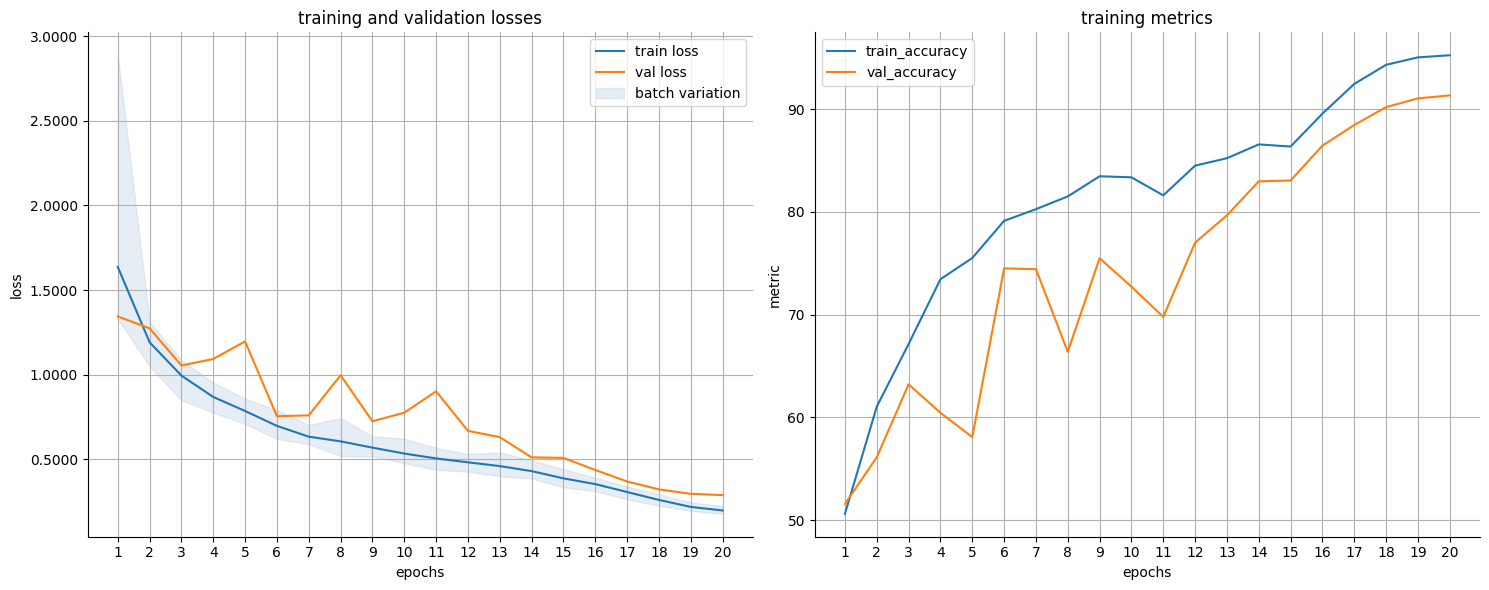

In [4]:
from models.mod_eight_layer_conv_net.architecture import ModEightLayerConvNet
from torch.optim.lr_scheduler import OneCycleLR
import math

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

trainset, valset, testset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_val=transform_val,
    normalize=False,
    use_validation_split=True
)

def train_model(model, model_name, num_epochs=200):

    max_lr = 0.1
    div_factor = 5          # controls initial LR: higher = lower start (max_lr/div_factor = 0.1/5 = 0.02)
    final_div_factor = 15   # controls decay speed: higher = faster decay (max_lr/final_div_factor = 0.1/15 ≈ 0.007)
    initial_lr = max_lr / div_factor
    
    # adjust warmup length based on absolute epochs, not percentage
    # absolute_warmup_epochs = 12
    # pct_start = absolute_warmup_epochs / num_epochs  # dynamically calculated
    pct_start = 0.23
   
    optimizer = SGD(
        model.parameters(),
        lr=initial_lr,
        momentum=0.9,
        weight_decay=0.01,
    )

    # calculate total steps
    steps_per_epoch = math.ceil(len(trainset) / 1024)
    total_steps = steps_per_epoch * num_epochs

    scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,                     # (1) Peak learning rate
        total_steps=total_steps,           # (2) Total number of training iterations
        pct_start=pct_start,               # (3) Percentage of training spent in warmup
        div_factor=div_factor,             # (4) Initial LR division factor  (Initial LR = max_lr/div_factor = 0.1/5 = 0.02)
        final_div_factor=final_div_factor, # (5) Final LR division factor    (Final LR = max_lr/final_div_factor = 0.1/15 ≈ 0.007)
        anneal_strategy='cos'              # (6) Type of annealing (default 'cos')
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=1024,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        step_scheduler_batch=True,

    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model2 = ModEightLayerConvNet()
trainer2 = train_model(model2, "ModEightLayerConvNet", num_epochs=20)

In [5]:
test_results_2 = trainer2.evaluate_on_test(test_set=testset)


Loading Best Model for Test Evaluation


Test Loss: 0.2998 | accuracy: 90.79


### Model Performance Insights
#### Class Accuracies

Our analysis shows that cats, birds, and dogs have the lowest accuracy rates among all classes. Cats perform the worst with around 80% accuracy rate, while most other classes (excluding these three) achieve accuracies above 93%.

To better understand our model's weakness with cats, we need to investigate what the model is confusing them with. This leads us to our next question: What specific patterns are causing the model to struggle with cat classification?

To answer this, we need to examine the confusion matrix, which will provide more granular metrics. Several scenarios could explain this performance:
1. The model might be producing false positives (e.g., incorrectly classifying dogs as cats)
2. The model might be generating false negatives (e.g., missing actual cats and classifying them as other classes)

Since accuracy alone cannot reveal these patterns, our next step is to analyze the confusion matrix for a detailed view of these misclassifications.

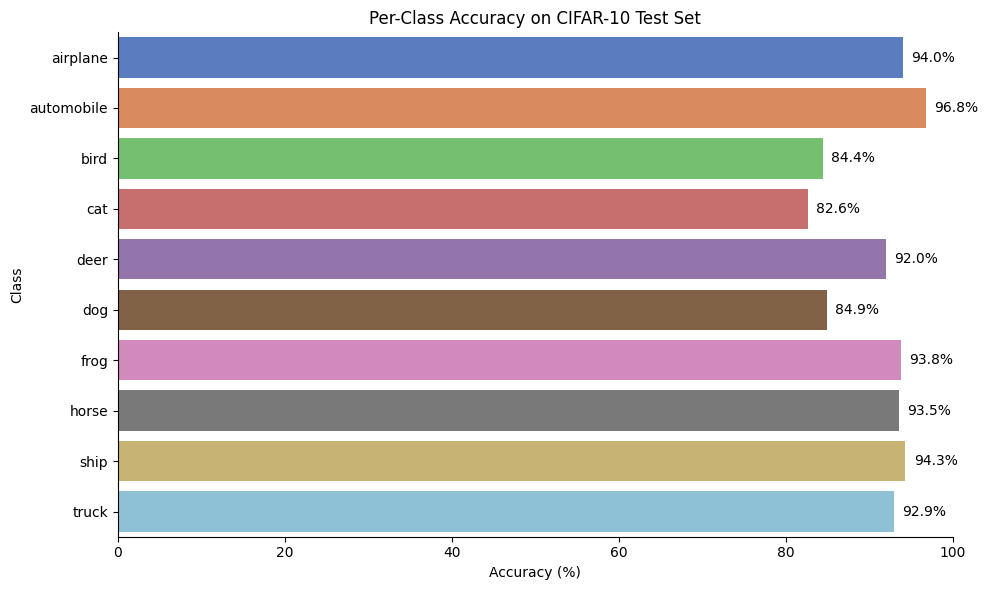

In [8]:
from src import MetricsPlotter
import numpy as np

predictions = test_results_2['predictions']
true_labels = test_results_2['true_labels']

# calculate per-class accuracy
class_correct = np.zeros(10)
class_total = np.zeros(10)
for i in range(len(true_labels)):
    label = true_labels[i]
    class_total[label] += 1
    if predictions[i] == label:
        class_correct[label] += 1

per_class_accuracy = (class_correct / class_total) * 100

# plot
plotter = MetricsPlotter()
ax = plotter.plot_class_accuracy(per_class_accuracy, testset.classes, dataset_name="CIFAR-10")

#### Confusion Matrix

The classification errors between cats and dogs appear to be bidirectional. The model frequently confuses cats with dogs and vice versa. 

As for birds, our third problematic class, the confusion is more distributed across various classes, though notably not with automobiles or trucks. 

While there are other patterns to explore, the cat/dog confusion stands out as the most significant issue. Given more time, we could investigate this further by implementing specialized data augmentations or more sophisticated convolution patterns to help the model better distinguish between these two classes. 

However, before considering such improvements, we need to deepen our understanding of the problem. Our next step is to examine the actual misclassified images to identify visual patterns that might explain the model's confusion. This analysis is crucial not only for understanding the current limitations but also for developing targeted solutions to improve the model's performance.

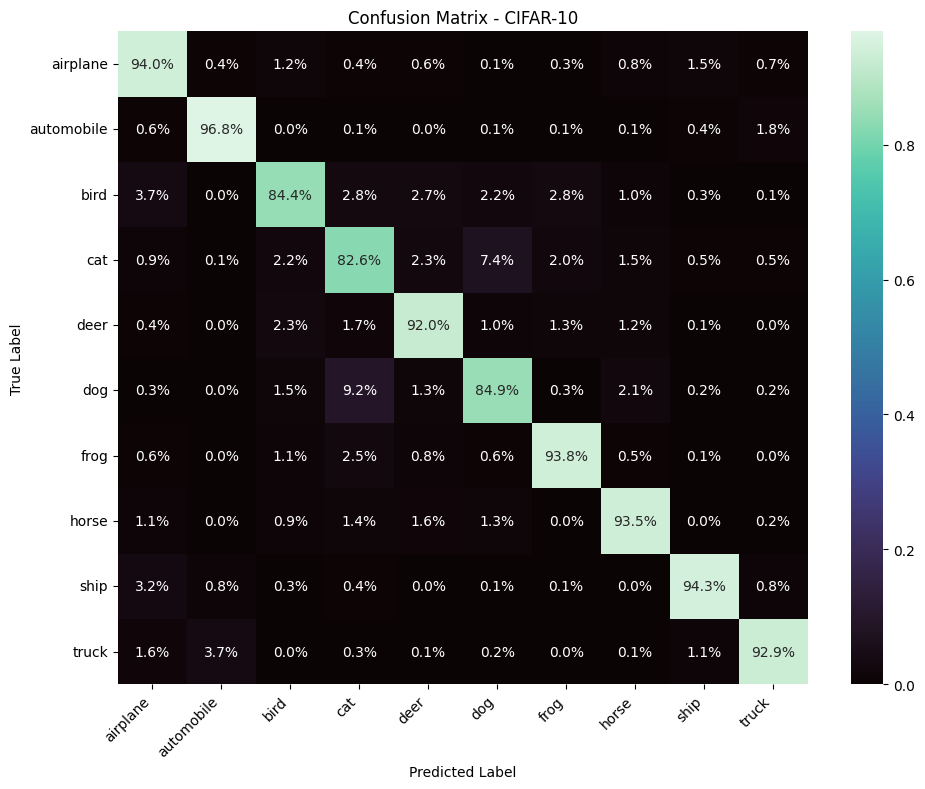

In [9]:
from matplotlib import pyplot as plt

# plot normalized confusion matrix
plotter.plot_confusion_matrix(
    predictions=predictions,
    true_labels=true_labels,
    class_names=testset.classes,
    dataset_name="CIFAR-10",
    normalize=True,
    cmap='mako'
)

plt.tight_layout()

#### Classification Examples: Cats vs Dogs

Looking at these comparison images, we can see interesting patterns in how our model handles cats and dogs. We've arranged the examples to show both misclassifications and correct predictions, and each time we run this code, we get new random examples to analyze.

The confusion between cats and dogs makes sense when you look closely. Dogs with prominent, pointed ears often get mistaken for cats, and when cats take certain poses that are typically "dog-like," the model gets confused. This isn't too surprising since they share many physical characteristics - both are four-legged animals that can look quite similar in certain poses.

What's interesting is that when the model makes mistakes, it's often not very confident in its prediction. We see quite a few cases where the confidence is below 50%, which actually gives us hope - the model isn't confidently wrong, it's unsure. The main takeaways from looking through these examples are:
- Pointy-eared dogs often trigger cat predictions
- Cats in certain poses (especially with heads down) get classified as dogs
- When image quality is poor, mistakes are more common, but that's not really the model's fault

These insights could be valuable for future improvements to the model.

As a side note, our third "bonus model" (which uses transfer learning with EfficientNet-B4) shows some interesting improvements in this area. It handles the dog-to-cat confusion much better - when it sees a dog, it rarely mistakes it for a cat anymore. However, it's fascinating that even this more sophisticated model still struggles with cats, occasionally misclassifying them as dogs. This persistent cat-to-dog confusion suggests there might be something fundamentally challenging about certain cat features that even advanced architectures find tricky to handle.


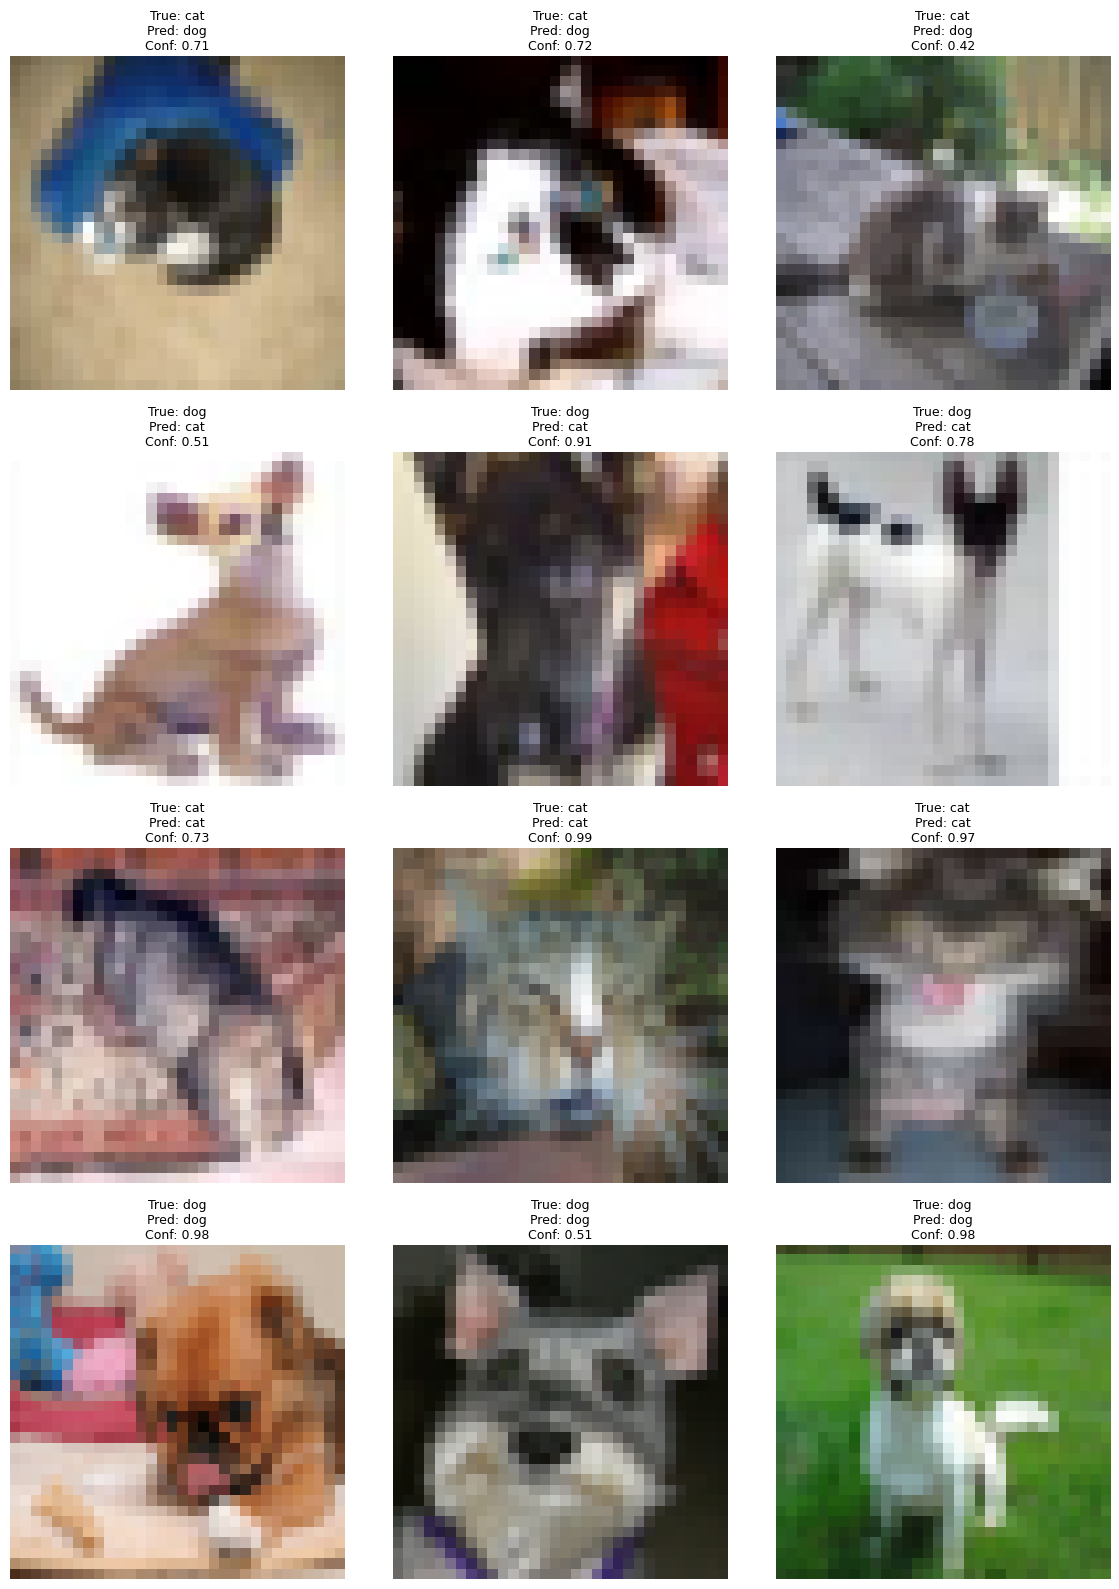

In [15]:
probabilities = test_results_2['probabilities']

# get images from test loader
images = []
for img, _ in test_results_2['test_loader']:
    images.extend(img.numpy())
images = np.array(images)

# create plotter
plotter = MetricsPlotter()

# Example 1: Look at cat-dog confusion
scenarios = [
    {'true': 'cat', 'pred': 'dog', 'n': 3},  # cats predicted as dogs
    {'true': 'dog', 'pred': 'cat', 'n': 3},  # dogs predicted as cats
    {'true': 'cat', 'pred': 'cat', 'n': 3},  # correctly classified cats
    {'true': 'dog', 'pred': 'dog', 'n': 3},  # correctly classified dogs
]

fig = plotter.plot_classification_examples(
    predictions=predictions,
    true_labels=true_labels,
    probabilities=probabilities,
    images=images,
    class_names=testset.classes,
    scenarios=scenarios
)

# fig.savefig('assets/classification_examples_cats_dogs.png')

### Bonus Model: Transfer Learning EfficientNet-B4

Files already downloaded and verified
Files already downloaded and verified
Loaded pretrained weights for efficientnet-b4
Using FP16 (half precision) training
[epoch 01] train loss: 0.4282 | val loss: 0.1369 | accuracy: 95.44%
Validation loss decreased (inf --> 0.1369). Saving model.


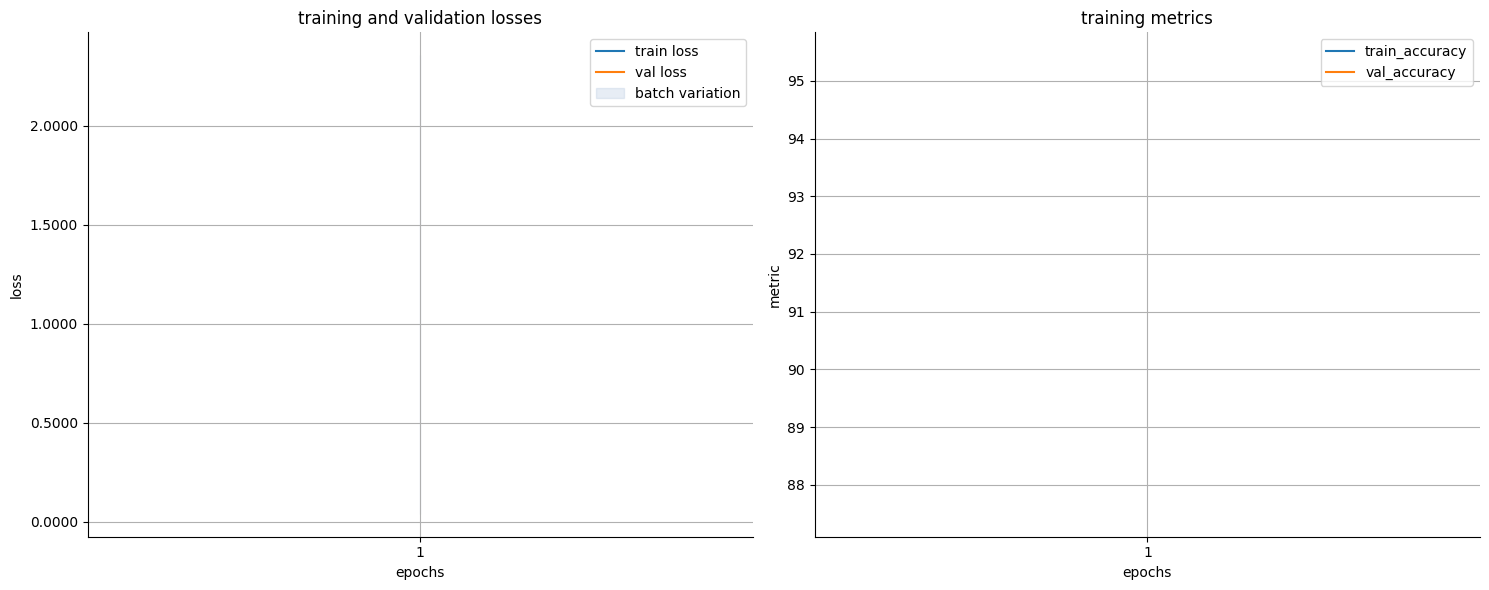

In [60]:
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import StepLR

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=160, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_val = transforms.Compose([
    transforms.Resize(200),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset, valset, testset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_val=transform_val,
    normalize=False,
    use_validation_split=True,
)

model3 = EfficientNet.from_pretrained('efficientnet-b4', num_classes=10)

optimizer = SGD(
    model3.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-6
)

scheduler = StepLR(
    optimizer,
    step_size=10,
    gamma=0.1
)

trainer3 = ModelTrainer(
    model=model3,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=32,
    verbose=True,
    save_metrics=False,
    early_stopping_patience=float('inf'),
    metrics=[accuracy],
    log_dir="logs/EfficientNet",
    logger_type="file"
)

trained_model3 = trainer3.train(
    training_set=trainset,
    val_set=valset,
    num_epochs=30
)

In [61]:
test_results_efficientnet = trainer3.evaluate_on_test(test_set=testset)

Loading Best Model for Test Evaluation
Test Loss: 0.1311 | accuracy: 95.87


Loading Best Model for Test Evaluation
Test Loss: 0.1311 | accuracy: 95.87


<Axes: title={'center': 'Confusion Matrix - CIFAR-10'}, xlabel='Predicted Label', ylabel='True Label'>

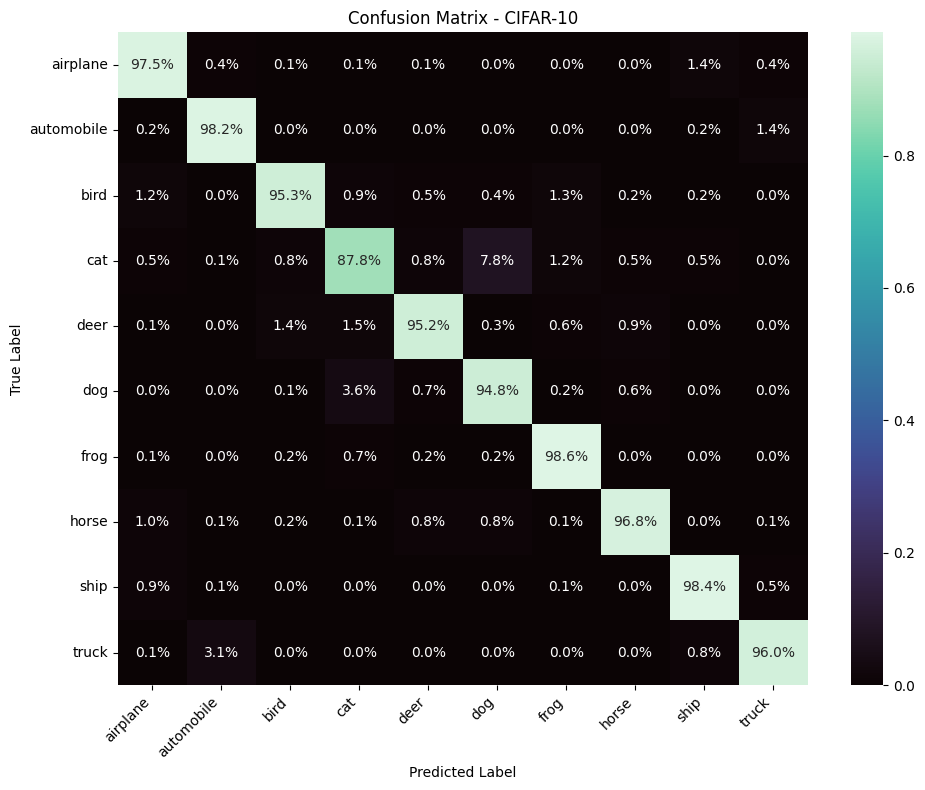

In [62]:
predictions_efficientnet = test_results_efficientnet['predictions']
true_labels_efficientnet = test_results_efficientnet['true_labels']

ax = plotter.plot_confusion_matrix(
    predictions=predictions_efficientnet,
    true_labels=true_labels_efficientnet,
    class_names=testset.classes,
    dataset_name="CIFAR-10",
    normalize=True,
    cmap='mako'
)